In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import (
    roc_auc_score,
    recall_score,
    f1_score,
    confusion_matrix,
    precision_score,
)
import xgboost as xgb
from xgboost import XGBClassifier
from nltk import edit_distance, jaccard_distance
import matplotlib.pyplot as plt


In [2]:
%load_ext nb_black
%load_ext autotime
%matplotlib inline

<IPython.core.display.Javascript object>

time: 8.01 ms (started: 2022-09-28 02:24:45 +02:00)


# Load Data

In [3]:
df = pd.read_csv("ds_challenge_alpas.csv", usecols=["entity_1", "entity_2", "tag"])

<IPython.core.display.Javascript object>

time: 5.79 s (started: 2022-09-28 02:24:45 +02:00)


# Check how balanced are the tags or classes in other words

In [88]:
df.tag.value_counts(dropna=False)

0    4162006
1    2880840
Name: tag, dtype: int64

<IPython.core.display.Javascript object>

time: 73.1 ms (started: 2022-09-28 23:56:22 +02:00)


### "Pipelines"

* Applying basic text cleaning: 
    * Making all strings lower case
    * Removing punctuation 
* Feature engineering 
    * Computing the `Levenshtein / Edit distance` between e1 and e2 
    * Computing the `Levenshtein / Edit distance` between tokenized e1 and e2 
    * Computing the `Jaccard distance` between tokenized e1 and e2
    * Counting the difference in string length between e1 and e2 
    * Counting the difference in token count between e1 and e2

# Why Jaccard and Levenstine?

Levenshtein distance is very useful to understand how similar two strings are, while taking into account the order.

In [42]:
edit_distance(["a", "b", "c"], ["a", "b", "c"])

0

<IPython.core.display.Javascript object>

time: 9.49 ms (started: 2022-09-28 23:22:36 +02:00)


In [41]:
edit_distance(["a", "b", "c"], ["c", "b", "a"])

2

<IPython.core.display.Javascript object>

time: 11.6 ms (started: 2022-09-28 23:22:26 +02:00)


However, sometimes the order is the only thing that changes, but the meaning is the same. And that's one of the cases where Jaccard is useful.

In [39]:
jaccard_distance(set(["a", "b", "c"]), set(["a", "b", "c"]))

0.0

<IPython.core.display.Javascript object>

time: 9.29 ms (started: 2022-09-28 23:21:59 +02:00)


In [5]:
def text_cleaning_pipeline(df):
    # make all characters lower case
    df["entity_1"] = df["entity_1"].str.lower()
    df["entity_2"] = df["entity_2"].str.lower()
    # remove punctuation
    df["entity_1"] = df["entity_1"].str.replace("[^\w\s]", "")
    df["entity_2"] = df["entity_2"].str.replace("[^\w\s]", "")

    return df

<IPython.core.display.Javascript object>

time: 3.54 ms (started: 2022-09-28 02:24:51 +02:00)


In [6]:
def feature_engineering_pipeline(df):
    # difference in string lengths
    df["len_delta"] = df.apply(
        lambda x: abs(len(x["entity_1"]) - len((x["entity_2"]))),
        axis=1,
    )
    # tokenize the strings
    df["entity_1_tokenized"] = df["entity_1"].str.split(" ")
    df["entity_2_tokenized"] = df["entity_2"].str.split(" ")

    # difference in the number of tokens
    df["token_count_delta"] = df.apply(
        lambda x: abs(len(x["entity_1_tokenized"]) - len((x["entity_2_tokenized"]))),
        axis=1,
    )
    # levenstein distance / edit distance - the lower it is the more similar the strings are
    df["l_distance"] = df.apply(
        lambda x: edit_distance(x["entity_1"], x["entity_2"]), axis=1
    )

    # levenstein distance / edit distance on tokenized strings
    df["l_distance_tokenized"] = df.apply(
        lambda x: edit_distance(x["entity_1_tokenized"], x["entity_2_tokenized"]),
        axis=1,
    )
    # jaccard distance - the lower it is the more similar the strings are
    df["j_distance_tokenized"] = df.apply(
        lambda x: jaccard_distance(
            set(x["entity_1_tokenized"]), set(x["entity_2_tokenized"])
        ),
        axis=1,
    )

    return df

<IPython.core.display.Javascript object>

time: 7.1 ms (started: 2022-09-28 02:24:51 +02:00)


# Pipeline

In [7]:
df = df.drop_duplicates(subset=["entity_1", "entity_2"])

<IPython.core.display.Javascript object>

time: 5.27 s (started: 2022-09-28 02:24:51 +02:00)


In [8]:
df = text_cleaning_pipeline(df)

<IPython.core.display.Javascript object>

time: 12.2 s (started: 2022-09-28 02:24:56 +02:00)


In [9]:
# edit distance on full strings is an expensive operation
df = feature_engineering_pipeline(df)

<IPython.core.display.Javascript object>

time: 51min 24s (started: 2022-09-28 02:25:08 +02:00)


In [10]:
FEATURES = [
    "l_distance",
    "l_distance_tokenized",
    "j_distance_tokenized",
    "len_delta",
    "token_count_delta",
]

TARGET = ["tag"]

ENTITIES = ["entity_1", "entity_2"]

<IPython.core.display.Javascript object>

time: 3.27 ms (started: 2022-09-28 03:16:33 +02:00)


# Samples for overview

In [11]:
df[FEATURES + TARGET].head()

,l_distance,l_distance_tokenized,j_distance_tokenized,len_delta,token_count_delta,tag
0,0,0,0.000000,0,0,1
1,31,3,1.000000,30,2,0
2,0,0,0.000000,0,0,1
3,7,1,0.666667,7,0,1
4,32,4,0.625000,32,3,1


<IPython.core.display.Javascript object>

time: 306 ms (started: 2022-09-28 03:16:33 +02:00)


In [12]:
df[ENTITIES + FEATURES + TARGET].head()

,entity_1,entity_2,l_distance,l_distance_tokenized,j_distance_tokenized,len_delta,token_count_delta,tag
0,preciform ab,preciform ab,0,0,0.000000,0,0,1
1,degener staplertechnik vertriebsgmbh,irshim,31,3,1.000000,30,2,0
2,alltel south carolina inc,alltel south carolina inc,0,0,0.000000,0,0,1
3,cse corporation,cse corp,7,1,0.666667,7,0,1
4,gruppo d motors srl,gruppo d motors sociedad de resposabilidad lim...,32,4,0.625000,32,3,1


<IPython.core.display.Javascript object>

time: 1.16 s (started: 2022-09-28 03:16:33 +02:00)


# First Look at the training

In [13]:
X_train_with_entities, X_test_with_entities, y_train, y_test = train_test_split(
    df[ENTITIES + FEATURES],
    df[TARGET],
)

# X_train_with_entities, X_test_with_entities - we keep this for later!!! Test the Pipeline Section
X_train, X_test = X_train_with_entities.drop(
    ENTITIES, axis=1
), X_test_with_entities.drop(ENTITIES, axis=1)

model = XGBClassifier(max_depth=2)
model.fit(X_train, y_train, eval_metric="auc")
y_pred = model.predict(X_test)

print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("R:", recall_score(y_test, y_pred))

print("P:", precision_score(y_test, y_pred))

ROC-AUC: 0.9989995905142502
[[1039232     687]
 [    966  719827]]
R: 0.9986598094043644
P: 0.9990465140163828


<IPython.core.display.Javascript object>

time: 38.1 s (started: 2022-09-28 03:16:34 +02:00)


# Distribution of predicted probabilities of having a match

The probabilities are not much more informative than just assigning a 0 or 1 class in this case since they mostly gravitate around 0 and 1. So this would require additional investigation to understand the model better. 

<AxesSubplot:>

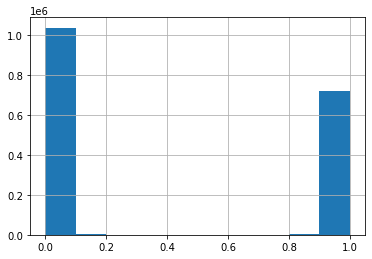

<IPython.core.display.Javascript object>

time: 393 ms (started: 2022-09-28 23:39:19 +02:00)


In [64]:
pd.DataFrame(model.predict_proba(X_test), columns=[0, 1])[1].hist()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Weight', ylabel='Features'>

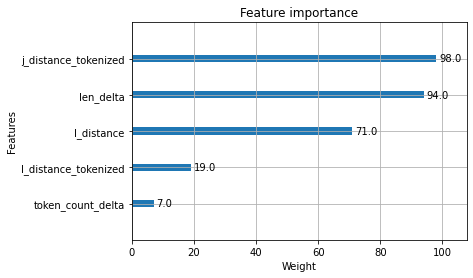

<IPython.core.display.Javascript object>

time: 92.1 ms (started: 2022-09-28 03:17:12 +02:00)


In [14]:
xgb.plot_importance(model, importance_type='weight', xlabel='Weight')


### Jaccard distance appears to be the feature with most weight, followed by the difference in string lengths and the Levensthein distance.

# Cross - Validation

In [15]:
scores = cross_validate(
    XGBClassifier(verbosity=0, max_depth=2),
    df[FEATURES],
    df[TARGET],
    cv=10,
    scoring=["recall", "precision", "roc_auc"],
)

<IPython.core.display.Javascript object>

time: 7min 18s (started: 2022-09-28 03:17:13 +02:00)


In [16]:
pd.DataFrame(scores)

,fit_time,score_time,test_recall,test_precision,test_roc_auc
0,43.721689,0.716339,0.998795,0.999028,0.999986
1,42.779762,0.711562,0.998705,0.999080,0.999985
2,41.198232,0.710496,0.998618,0.999118,0.999985
3,42.827997,0.705750,0.998712,0.998948,0.999988
4,42.157859,0.694645,0.998754,0.999056,0.999985
5,45.027830,0.707682,0.998750,0.998983,0.999986
6,42.501136,0.701101,0.998702,0.998958,0.999984
7,43.910846,0.691099,0.998761,0.998965,0.999987
8,43.173896,0.701338,0.998667,0.998955,0.999984
9,43.247154,0.700358,0.998764,0.999090,0.999985


<IPython.core.display.Javascript object>

time: 8.43 ms (started: 2022-09-28 03:24:31 +02:00)


### The metrics seem stable for all the splits. 

# Test the Prototype 

In [54]:
def transform_input(e1, e2):
    df = pd.DataFrame([[e1, e2]], columns=["entity_1", "entity_2"])
    df = text_cleaning_pipeline(df)
    df = feature_engineering_pipeline(df)

    return df


def get_entity_similarity(e1, e2, model):
    df = transform_input(e1, e2)
    probs = model.predict_proba(df[FEATURES])
    return round(probs[0][1], 4)


def get_random_entity_pair(df):
    return df.sample()[["entity_1", "entity_2"]].values.flatten().tolist()

<IPython.core.display.Javascript object>

time: 10.2 ms (started: 2022-09-28 23:32:14 +02:00)


In [57]:
for item in range(0, 20):
    e1, e2 = get_random_entity_pair(X_test_with_entities)
    print(
        f"""
    E1: {e1}
    E2: {e2}
    """
    )
    print(f"SIMILARITY: {get_entity_similarity(e1,e2, model):.3f}")


    E1: granite city armored car inc
    E2: granite city armored car inc
    
SIMILARITY: 1.000

    E1: lcy technology corporationoration
    E2: pacific crest industries inc
    
SIMILARITY: 0.000

    E1: isdn holdings ltd
    E2: tristate camera and
    
SIMILARITY: 0.000

    E1: ysofer esca
    E2: hekamerk ou
    
SIMILARITY: 0.000

    E1: ultra packaging inc
    E2: hansa plastics inc
    
SIMILARITY: 0.005

    E1: ekoil a w likwidacji sp
    E2: allsun
    
SIMILARITY: 0.000

    E1: luoyang glass coltd
    E2: olivertolas healthcare packaging
    
SIMILARITY: 0.000

    E1: freas glass works inc
    E2: freas glass works inc
    
SIMILARITY: 1.000

    E1: audio dynamix
    E2: flying whales
    
SIMILARITY: 0.000

    E1: prime tanning corp
    E2: prime tanning corp
    
SIMILARITY: 1.000

    E1: triad freightliner of
    E2: trustee for parrish
    
SIMILARITY: 0.000

    E1: ergon inc
    E2: clay ingels
    
SIMILARITY: 0.000

    E1: fuga uros sa
    E2: fuga couro

<IPython.core.display.Javascript object>

time: 714 ms (started: 2022-09-28 23:35:35 +02:00)


# Explore missclassified items

In [105]:
df_predicted = pd.DataFrame(y_pred, columns=["predicted"])
df_explore = X_test_with_entities.join(y_test)
df_explore["predicted"] = df_predicted["predicted"].values

<IPython.core.display.Javascript object>

time: 263 ms (started: 2022-09-29 00:02:06 +02:00)


In [106]:
df_explore["miss"] = abs(df_explore["tag"] - df_explore["predicted"])

<IPython.core.display.Javascript object>

time: 24.1 ms (started: 2022-09-29 00:02:12 +02:00)


In [108]:
df_explore[df_explore["miss"] == 1]

,entity_1,entity_2,l_distance,l_distance_tokenized,j_distance_tokenized,len_delta,token_count_delta,tag,predicted,miss
5733959,datecs ood,datecs drujestvo s ogranichena,21,3,0.800000,20,2,1,0,1
2049929,cls inc,xfmrs inc,4,1,0.666667,2,0,0,1,1
2154111,richard sociedade anônimanders,richard sanders nissan,16,2,0.800000,8,0,1,0,1
3132148,pat salmon and sons inc,mike and sons oil,13,3,0.714286,6,1,0,1,1
574669,la spa ou,la sociedad por acciones,17,3,0.833333,15,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...
6616638,oil technology,optus resin technology,9,2,0.750000,8,1,0,1,1
6479665,hoppygo společnost s ručením omezeným,hoppygo sro,26,4,0.833333,26,3,1,0,1
1527833,dart sa de cv,dart sociedade anônima,13,3,0.833333,9,1,1,0,1
2562716,pacific marine systems,pls pacific laser systems,9,2,0.600000,3,1,0,1,1


<IPython.core.display.Javascript object>

time: 46 ms (started: 2022-09-29 00:03:18 +02:00)


The model struggles with abbreviations. 

ie. "futurex lp" and "futurex limited liability partnership" are the same thing, but we missclassified it. 
ie. "la spa" ou and "la sociedad por acciones"
 
The other issue is because to much weight is given to jaccard similarity: 
i.e "oil technology" and "optus resin technolog" obviously not the same, but we missclassified it. 

# How to deploy?

Assuming that we would want to create a microservice, I would separate the system into 2 parts:
    * Model Retraining 
    * Model Serving 
    
### Model Retrainign 

We could have a simple .py script that follows the steps:

```
df = text_cleaning_pipeline(df) # function provided above
df = feature_engineering_pipeline(df) # function provided above

FEATURES = [
"l_distance",
"l_distance_tokenized",
"j_distance_tokenized",
"len_delta",
"token_count_delta",
]

TARGET = ["tag"]

model = XGBClassifier(max_depth=2)
model.fit(X_train, y_train, eval_metric="auc")
y_pred = model.predict(X_test)

# For monitoring purposses 
print("ROC-AUC:", roc_auc_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("R:", recall_score(y_test, y_pred))

print("P:", precision_score(y_test, y_pred))

model.to_pickle()
```

### Model Serving

Simple API with 2 input parameters entity_1 and entity_2
which are then passed to: 

```
    get_entity_similarity(e1,e2, model) # function provided above 
```

For the API we could use FastAPI or Flask 

All of this should be dockerized and can be hosted with a cloud provider such as AWS where we can spin an instance and run a docker image containing the service and model retraining. 
